# Adaptive Intelligence Assignment 2

I provide here an Python implementation of the Reinforcement Learning algorithms described in the assignment.
This code is an extension of the code provided in the lab week 8 of the module, therefore, a major part of the credit goes to this implementation. 

In [248]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
def get_min_steps(x, y):
    return (abs(x[0]-y[0]) + abs(x[1]-y[1]))

def homing_nn(n_trials,n_steps,learning_rate,eps,gamma,lam,weights_display=False, tracking_matrix_display=False, 
             direction_matrix_display=False):
    ## Definition of the environment
    N = 10                               #height of the gridworld ---> number of rows
    M = 10                              #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    tracking_matrix = np.zeros((N, M)) # A matrix to store the previously explored states
    direction_matrix = np.zeros((N, M)) # A matrix to store the preferred location per state
    states_matrix = np.eye(N_states)
    N_actions = 4                                           #number of possible actions in each state: 1->N 2->E 3->S 4->W
    action_row_change = np.array([-1,0,+1,0])               #number of cell shifted in vertical as a function of the action
    action_col_change = np.array([0,+1,0,-1])               #number of cell shifted in horizontal as a function of the action
    End = np.array([9, 2])                                  #terminal state--->reward
    s_end = np.ravel_multi_index(End,dims=(N,M),order='F')  #terminal state. Conversion in single index
    
    ## Rewards
    R = 1                              #only when the robot reaches the charger, sited in End state

    ## Variables
    weights = np.random.rand(N_actions,N_states)
    learning_curve = np.zeros((1,n_trials))
    extra_steps = np.zeros((1, n_trials)) # Show the extra-steps vis-a-vis or shortest-path
    
    # Eligibility Trace Matrix
    e = np.zeros((N_actions, N_states))

    # Obstacles matrix
    obstacles = np.array(([0, 5], [1, 5], [2, 5], [3, 5], 
                [5, 3], [6, 3], [7, 3], [8, 3], [9, 3], 
                [7, 6], [7, 7], [7, 8], [7,9]))
    
    ## SARSA

    # Start trials
    for trial in range(n_trials):
        
        # Initialisation
        Start = np.array([np.random.randint(N),np.random.randint(M)])   #random start
        s_start = np.ravel_multi_index(Start,dims=(N,M),order='F')      #conversion in single index
        min_steps = get_min_steps(Start, End)
        state = Start                                                   #set current state
        s_index = s_start                                               #conversion in single index
        step = 0

        # Start steps
        while s_index != s_end and step <= n_steps:

            r_walls = 0
            step += 1
            learning_curve[0,trial] = step

            input_vector = states_matrix[:,s_index].reshape(N_states,1)         #convert the state into an input vector

            #compute Qvalues. Qvalue=logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig

            #eps-greedy policy implementation
            greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
            if greedy:
                action = np.argmax(Q)                           #pick best action
            else:
                action = np.random.randint(N_actions)           #pick random action
                
            direction_matrix[state[0]][state[1]] += action

            state_new = np.array([0,0])
            #move into a new state
            state_new[0] = state[0] + action_row_change[action]
            state_new[1] = state[1] + action_col_change[action]

            #put the robot back in grid if it goes out and give negative reward
            if state_new[0] < 0:
                r_old = -0.1
                state_new = state
            if state_new[0] >= N:
                r_old = -0.1
                state_new = state
            if state_new[1] < 0:
                r_old = -0.1
                state_new = state
            if state_new[1] >= M:
                r_old = -0.1
                state_new = state
            
            # move the robot to it's previous location if it bounces into a wall and give negative reward.
            if any(np.equal(obstacles,state_new).all(1)):
                r_old = -0.1
                state_new = state

            s_index_new = np.ravel_multi_index(state_new,dims=(N,M),order='F')  #conversion in a single index
            
            ## TODO update Qvalues. Only if is not the first step
            if step > 1:
                delta = r_old - Q_old + gamma * Q[action]
                e[action_old, s_index] += 1
                e = e * gamma * lam + (output_old.dot(input_old.T))
                dw = learning_rate * delta * e 
                weights += dw
            
            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions,1))
            output[action] = 1

            #update variables
            input_old = input_vector
            output_old = output
            Q_old = Q[action]
            r_old = 0            
            
            state[0] = state_new[0]
            state[1] = state_new[1]
            
            # SARSA-Lambda
            action_old = action
            s_index = s_index_new
            
            # Tracking Matrix Update
            tracking_matrix[state_new[0]][state_new[1]] += 1
        
            ## TODO: check if state is terminal and update the weights consequently
            if s_index == s_end:
                delta = R + (gamma * Q[action]) - Q_old
                e[action_old, s_index] += 1
                e = e * gamma * lam + (output_old.dot(input_old.T))
                dw = learning_rate * delta * e 
                weights += dw
            if step == n_steps:
                delta = -R + (gamma * Q[action]) - Q_old
                e[action_old, s_index] += 1
                e = e * gamma * lam + (output_old.dot(input_old.T))
                dw = learning_rate * delta * e 
                weights += dw
                
        extra_steps[0,trial] = step - min_steps
        
    if weights_display:
        return weights
    elif tracking_matrix_display:
        return tracking_matrix
    elif direction_matrix_display:
        return direction_matrix
    else:
        return extra_steps

In [250]:
# Parameter setup
nrepetitions = 5;  # number of runs for the algorithm
nTrials = 2000;     # should be integer >0
nSteps = 50;        # maximum number of allowed steps 
learningRate = 1;   # should be real, Greater than 0
epsilon = 0;        # should be real, Greater or Equal to 0; epsion=0 Greedy, otherwise epsilon-Greedy
gamma = 0.9;        # should be real, positive, smaller than 1
lam = 0;


total_extra_steps = np.zeros((nrepetitions,nTrials))
parameters = np.arange(0, 1.1, 0.1)
results = []

for j in range(nrepetitions):
    print(j)
    total_extra_steps[j,:] = homing_nn(nTrials,nSteps,learningRate,epsilon,gamma,lam)
means = np.mean(total_extra_steps, axis=0)

0
1
2
3
4


4.134266666666666


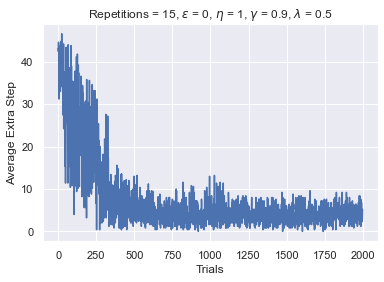

In [251]:
plt.title("Repetitions = 15, $\epsilon$ = 0, $\eta$ = 1, $\gamma$ = 0.9, $\lambda$ = 0.5")
plt.plot(means)
plt.xlabel("Trials")
plt.ylabel("Average Extra Step")
av_steps_500 = np.mean(means[500:])
print(av_steps_500)

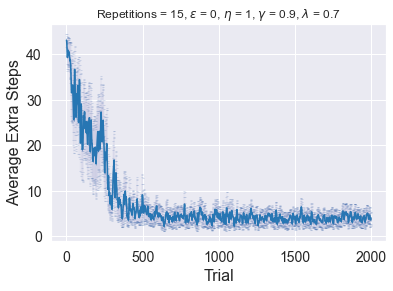

In [252]:
from scipy.ndimage import gaussian_filter1d

errors = np.std(total_extra_steps, axis = 0) / np.sqrt(nrepetitions) # errorbars are equal to twice standard error i.e. std/sqrt(samples)

smooth_means = gaussian_filter1d(means, 2)
smooth_errors = gaussian_filter1d(errors, 2)

plt.errorbar(np.arange(nTrials), smooth_means, smooth_errors, 0, elinewidth = 0.1, capsize = 1, alpha =0.2)
plt.plot(smooth_means, 'tab:blue') # Plot the mean on top to standout

plt.title("Repetitions = 15, $\epsilon$ = 0, $\eta$ = 1, $\gamma$ = 0.9, $\lambda$ = 0.7")
plt.xlabel('Trial',fontsize = 16)
plt.ylabel('Average Extra Steps',fontsize = 16)
plt.tick_params(axis = 'both', which='major', labelsize = 14)
plt.savefig('lam_0.7.png', dpi=300)
plt.show()

In [253]:
#x = homing_nn(nTrials,nSteps,learningRate,epsilon,gamma,lam,weights_display=True)

In [254]:
'''def column(matrix, i):
    return [row[i] for row in matrix]

# rows = actions
# columns = states

results = np.zeros(100)

for i in range(len(x[0])):
    p = column(x, i)
    arg_max = np.argmax(p)
    results[i] = arg_max
    
results = results.reshape(10,10)'''

'def column(matrix, i):\n    return [row[i] for row in matrix]\n\n# rows = actions\n# columns = states\n\nresults = np.zeros(100)\n\nfor i in range(len(x[0])):\n    p = column(x, i)\n    arg_max = np.argmax(p)\n    results[i] = arg_max\n    \nresults = results.reshape(10,10)'

In [255]:
import seaborn as sns
sns.set()

#sns.heatmap(results.astype(int), annot=True, fmt="d")
# 0->N 1->E 2->S 3->W

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 1.0, 'Distribution of Explored States')

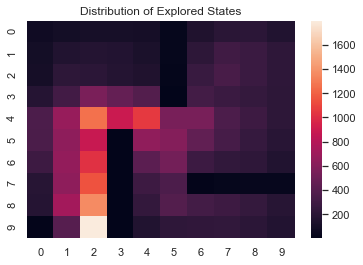

In [256]:
x = np.zeros((10,10))

for j in range(15):
    print(j)
    x += homing_nn(nTrials,nSteps,learningRate,epsilon,gamma,lam,tracking_matrix_display=True)
    
x = x/15

ax = plt.axes()
sns.heatmap(x.astype(int), ax = ax)
ax.set_title('Distribution of Explored States')

0
1
2
3
4
[[ 133.  197.  209.  182.  212.   58.  300.  367.  458.  272.]
 [ 128.  270.  292.  371.  272.   73.  285.  332.  503.  348.]
 [ 187.  406.  447.  439.  294.   64.  377.  417.  456.  326.]
 [ 132.  599.  557.  284.  253.   35.  468.  786.  666.  398.]
 [ 576. 1722. 2820. 3071. 3029. 1940. 1866. 1265.  474.  393.]
 [ 402. 1752. 2326.   70.  128.  574.  425.  366.  336.  268.]
 [ 117. 1711. 2717.   77.  173.  484.  248.  250.  387.  308.]
 [  73. 1443. 2053.   58.  243.  331.   46.   79.   73.   82.]
 [  46. 1106. 2796.   69.  247.  531.  644.  495.  468.  391.]
 [  38.  409.    0.   65.  192.  290.  408.  510.  499.  313.]]


Text(0.5, 1.0, 'Distribution of Directions')

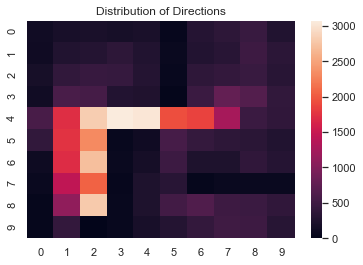

In [260]:
x = np.zeros((10,10))

for j in range(5):
    print(j)
    x += homing_nn(nTrials,nSteps,learningRate,epsilon,gamma,lam,direction_matrix_display=True)
    
x = x/(5)
x = np.round(x)

print(x)

ax = plt.axes()
sns.heatmap(x.astype(int), ax = ax)
ax.set_title('Distribution of Directions')